# Exploring and Predicting Severe Road Traffic Crashes with Machine Learning Models

Richard Wen  
rwen@ryerson.ca


## Setup

### Python Libraries

The following Python3 libraries are used:

* `geopandas` and `pandas` for data processing
* `plotly` for interactive plots
* `folium` for interactive maps
* `matplotlib` for static plots and maps 
* `sklearn` for machine learning

In [1]:
import calendar
import cufflinks as cf
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.graph_objects as go
import pandas as pd

from matplotlib.colors import ListedColormap
from pandas.api.types import is_string_dtype
from shapely.geometry import Point

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

### Configuration

Then, we have to configure `cufflinks` and `plotly` for offline notebook plotting. We also set the `cufflinks` plot theme and the number of columns to display when we present tables.

In [2]:
cf.go_offline()
cf.set_config_file(theme = 'white')
plotly.offline.init_notebook_mode(connected = True)
pd.set_option('display.max_columns', None)

### Setting Variables

Finally, we apply some re-usable global settings for our notebook:

* `map_style`: map style for base maps (see [plotly mapbox styles](https://plot.ly/python/mapbox-layers/))
* `map_margins`: margins for the map, we decrease this to give more space for the map (except for the top, which contains the title)

In [3]:
plotly_map_style = 'carto-positron'
folium_map_style = 'CartoDB positron'
map_margins = {'l': 0, 'r': 0, 'b': 0, 't': 35}

## Introduction

### Traffic Collisions Wordwide

* 3700+ traffic collisions per day
* Over a million lives lost every year

### Vision Zero

* Road safety policy for designing safer transportation
* ~22\% reduction in traffic deaths

In [4]:
vzero = pd.DataFrame({'Year': ['Before (1997)', 'After (2006)'], 'Deaths Per 100,000': [6, 4.7]})
vzero.iplot('bar',
            margin = dict(l=200, r=200),
            title = 'Traffic Deaths Per 100,000',
            x = 'Year',
            ticktext = vzero.Year.to_list(),
            tickvals= vzero.Year.to_list(),
            y = 'Deaths Per 100,000')

### Data as a Hint

* Analyze and evaluate effects of engineering and policy changes
* Gives us an idea of whether certain designs or policies work
* Massive amounts of open data available

### Experiment Objectives

1. Explore and gain insight on severe road collisions with open data
2. Test some basic machine learning models to predict the collisions
3. Evaluate how changes to model parameters affect the collisions

## Data Exploration

### Datasets

* [Toronto Police Service Public Safety Data](http://data.torontopolice.on.ca/)
    * Killed or Seriously Injured (KSI) Collisions
* [City of Toronto Open Data](https://open.toronto.ca/)
    * Centrelines of streets, walkways, rivers, etc (2.5m positional accuracy)

### Supplementary Data

Some supplementary data will be used to support the data analysis. These data are not the main of the analysis.

#### Toronto Boundaries

The [geospatial boundaries](https://open.toronto.ca/dataset/regional-municipal-boundary/) for the City of Toronto as a `.shp` file from the [Open Data Catalogue](https://open.toronto.ca).

**Note**: The data was converted from a shapefile `.shp` to a `.geojson` file using [QGIS](https://www.qgis.org/en/site/).

In [5]:
toronto = gpd.read_file('data/city-of-toronto/toronto.geojson')
toronto

,AREA_ID,AREA_NAME,OBJECTID,geometry
0,49886,Toronto,13448849,"MULTIPOLYGON (((-79.33131 43.62580, -79.33133 ..."


In [6]:
toronto_map = folium.Map(
    location = [toronto.geometry.centroid.y, toronto.geometry.centroid.x],
    tiles = folium_map_style,
    zoom_start = 11
)
folium.GeoJson(toronto, name = 'Toronto, ON').add_to(toronto_map)
toronto_map

### Killed or Seriously Injured (KSI) Collisions

* Police reports where officer attended collision event
* Only major (admitted to hospital) or fatal (death) injuries
* Every row is one person involved

[Toronto Police Public Safety Data Portal](http://data.torontopolice.on.ca/datasets/ksi):

> The Killed and Seriously Injured (KSI) data is a subset dataset from all traffic collision events. The source of the data comes from police reports where an officer attended an event related to a traffic collision.
>
> Please note that this dataset does not include all traffic collision events. The KSI data only includes events where a person sustained a major or fatal injury in a traffic collision event.The following definitions relate to the severity of injury used to classify the events in this dataset.
>
> * **Major Injury**: A non-fatal injury that is severe enough to require the injured person to be admitted to hospital, even if only for observation at the time of the collision. Includes: fracture, internal injury, severe cuts, crushing, burns, concussion, severe general shocks.
> * **Fatal**: Fatal injury (person sustains bodily injuries resulting in death) only those cases where death occurs in less than 366 days as result of the collision. “Fatal” does not include death from natural causes (heart attack, stroke, epilated seizure, etc.) or suicide.
> * **Note**: Other injury types including minor or none are associated to every individual included in the event.The KSI data includes a record (row) for every person involved in the collision event regardless of their level of injury, it includes everyone who was involved in a particular collision event. The field “Index” provides an arbitrary unique identification for every record in the entire dataset.
>
> The “ACCNUM” is a unique identification for each traffic collision event. Since the data includes every person involved in a collision event, this identification is duplicated. Please note that this number is not unique and it may repeat year over year. Careful consideration must be made when creating a subset for unique events, as the detailed information provided is for every person involved and its associated role and information may be lost.
>
> For example, the event with ACCNUM=6000607400 has 5 persons involved in the collision (5 records). The field “INVTYPE” indicates the role of the person in the collision event. The “INVAGE” indicates the age range of the person and the “INJURY” type indicates the level of injury they sustained. Therefore, this event can be interpreted in the following way:1.  Passenger 1 age 20 to 24 sustained a fatal injury.2.  Passenger 2 age 15-19 sustained a fatal injury.3.  Passenger 3 age 20 to 24 sustained a major injury4.  Driver age 1 20 to 24 sustained a major injury.5.  Driver 2 age 45 to 49 sustained a major injury

In [7]:
# Set data source paths
ksi_data_url = 'https://opendata.arcgis.com/datasets/88e8040e02d5493eb163e454140d3a34_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'
ksi_file_path = 'data/toronto-police/ksi.csv'

# Read the file
try:
    ksi = pd.read_csv(ksi_data_url)
except:
    ksi = pd.read_csv(ksi_file_path)
ksi.head()

,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,OFFSET,ROAD_CLASS,District,WardNum,WardNum_X,WardNum_Y,Division,Division_X,Division_Y,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,Neighbourh,ObjectId
0,-79.412438,43.767462,80221198,4003162994,2014,2014-10-24T04:00:00.000Z,2315,23,YONGE ST,HILLCREST AVE,,Major Arterial,North York,18,0,0,32,0,0,43.767462,-79.412438,Intersection,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Sideswipe,Passenger,unknown,None,0,,,,,,,,,,,,,,Yes,,,Yes,,Yes,,,,,,51,Willowdale East (51),12001
1,-79.516246,43.718318,80565670,6001093797,2016,2016-06-22T04:00:00.000Z,2315,23,120 BEVERLY HILLS DR,,65 m South of,Collector,Etobicoke York,7,0,0,31,0,0,43.718318,-79.516246,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,25 to 29,None,0,South,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,,,,,,,Yes,,Yes,,,,,Yes,,,,,,26,Downsview-Roding-CFB (26),12002
2,-79.516246,43.718318,80565671,6001093797,2016,2016-06-22T04:00:00.000Z,2315,23,120 BEVERLY HILLS DR,,65 m South of,Collector,Etobicoke York,7,0,0,31,0,0,43.718318,-79.516246,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Passenger,30 to 34,None,0,,,,,,,,,,,,Yes,,Yes,,,,,Yes,,,,,,26,Downsview-Roding-CFB (26),12003
3,-79.516246,43.718318,80565672,6001093797,2016,2016-06-22T04:00:00.000Z,2315,23,120 BEVERLY HILLS DR,,65 m South of,Collector,Etobicoke York,7,0,0,31,0,0,43.718318,-79.516246,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,10 to 14,Major,0,East,,,,,Vehicle hits the pedestrian walking or running...,"Crossing, no Traffic Control",Inattentive,,,,Yes,,Yes,,,,,Yes,,,,,,26,Downsview-Roding-CFB (26),12004
4,-79.374309,43.662909,80632379,6002153175,2016,2016-12-04T05:00:00.000Z,2315,23,CARLTON STREET,HOMEWOOD AVENUE,,Minor Arterial,Toronto and East York,13,0,0,51,0,0,43.662909,-79.374309,Intersection,At Intersection,No Control,Rain,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,75 to 79,None,0,East,"Automobile, Station Wagon",Turning Left,Failed to Yield Right of Way,Inattentive,,,,,,,Yes,,Yes,,,,,,,Yes,,,,73,Moss Park (73),12005


Notice here that there a few columns with 'Yes' values in them, and that the `DATE` column is in text only. We will need to preprocess these later for our analyses and exploration.

#### KSI Data Cleaning

The following data cleaning was applied to the KSI data:

* [Universal Time Coordinated (UTC)](https://www.iso.org/iso-8601-date-and-time-format.html) to date object
* Columns with `Yes` to `1` and `0` otherwise
* Aggregate by `ACCNUM` (represents unique collision identifier)
* Convert to geospatial data using `LONGITUDE` and `LATITUDE`

The date is in [ISO 8601 UTC](https://www.iso.org/iso-8601-date-and-time-format.html) format, but needs to be converted into a date time object using [pd.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html).

In [8]:
ksi.DATE = pd.to_datetime(ksi.DATE)
ksi.DATE

0       2014-10-24 04:00:00+00:00
1       2016-06-22 04:00:00+00:00
2       2016-06-22 04:00:00+00:00
3       2016-06-22 04:00:00+00:00
4       2016-12-04 05:00:00+00:00
                   ...           
12239   2009-07-26 04:00:00+00:00
12240   2009-07-26 04:00:00+00:00
12241   2009-07-26 04:00:00+00:00
12242   2014-03-29 04:00:00+00:00
12243   2017-11-28 05:00:00+00:00
Name: DATE, Length: 12244, dtype: datetime64[ns, UTC]

Next we should convert some of the variables with `Yes` to 1 (`Yes`) and 0 (`No`) so we can obtain counts for each variable, and perform numerical computation.

In [9]:
# Get the columns with 'Yes' in it
ksi_str_columns = [c for c in ksi.columns if is_string_dtype(ksi[c])]
ksi_yes_columns = [c for c in ksi_str_columns if 'Yes' in ksi[c].values]

# If there are any 'Yes' columns, convert them to 1 and 0
if len(ksi_yes_columns) > 0:
    ksi[ksi_yes_columns] = ksi[ksi_yes_columns].apply(lambda c: [1 if r == 'Yes' else 0 for r in c])
ksi

,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,OFFSET,ROAD_CLASS,District,WardNum,WardNum_X,WardNum_Y,Division,Division_X,Division_Y,LATITUDE,LONGITUDE,LOCCOORD,ACCLOC,TRAFFCTL,VISIBILITY,LIGHT,RDSFCOND,ACCLASS,IMPACTYPE,INVTYPE,INVAGE,INJURY,FATAL_NO,INITDIR,VEHTYPE,MANOEUVER,DRIVACT,DRIVCOND,PEDTYPE,PEDACT,PEDCOND,CYCLISTYPE,CYCACT,CYCCOND,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Hood_ID,Neighbourh,ObjectId
0,-79.412438,43.767462,80221198,4003162994,2014,2014-10-24 04:00:00+00:00,2315,23,YONGE ST,HILLCREST AVE,,Major Arterial,North York,18,0,0,32,0,0,43.767462,-79.412438,Intersection,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Sideswipe,Passenger,unknown,None,0,,,,,,,,,,,,0,0,1,0,0,1,0,1,0,0,0,0,0,51,Willowdale East (51),12001
1,-79.516246,43.718318,80565670,6001093797,2016,2016-06-22 04:00:00+00:00,2315,23,120 BEVERLY HILLS DR,,65 m South of,Collector,Etobicoke York,7,0,0,31,0,0,43.718318,-79.516246,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,25 to 29,None,0,South,"Automobile, Station Wagon",Going Ahead,Driving Properly,Normal,,,,,,,1,0,1,0,0,0,0,1,0,0,0,0,0,26,Downsview-Roding-CFB (26),12002
2,-79.516246,43.718318,80565671,6001093797,2016,2016-06-22 04:00:00+00:00,2315,23,120 BEVERLY HILLS DR,,65 m South of,Collector,Etobicoke York,7,0,0,31,0,0,43.718318,-79.516246,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Passenger,30 to 34,None,0,,,,,,,,,,,,1,0,1,0,0,0,0,1,0,0,0,0,0,26,Downsview-Roding-CFB (26),12003
3,-79.516246,43.718318,80565672,6001093797,2016,2016-06-22 04:00:00+00:00,2315,23,120 BEVERLY HILLS DR,,65 m South of,Collector,Etobicoke York,7,0,0,31,0,0,43.718318,-79.516246,Mid-Block,Non Intersection,No Control,Clear,"Dark, artificial",Dry,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,10 to 14,Major,0,East,,,,,Vehicle hits the pedestrian walking or running...,"Crossing, no Traffic Control",Inattentive,,,,1,0,1,0,0,0,0,1,0,0,0,0,0,26,Downsview-Roding-CFB (26),12004
4,-79.374309,43.662909,80632379,6002153175,2016,2016-12-04 05:00:00+00:00,2315,23,CARLTON STREET,HOMEWOOD AVENUE,,Minor Arterial,Toronto and East York,13,0,0,51,0,0,43.662909,-79.374309,Intersection,At Intersection,No Control,Rain,"Dark, artificial",Wet,Non-Fatal Injury,Pedestrian Collisions,Driver,75 to 79,None,0,East,"Automobile, Station Wagon",Turning Left,Failed to Yield Right of Way,Inattentive,,,,,,,1,0,1,0,0,0,0,0,0,1,0,0,0,73,Moss Park (73),12005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12239,-79.330990,43.804445,5273577,1119725,2009,2009-07-26 04:00:00+00:00,236,2,3330 PHARMACY Aven,,,Minor Arterial,Scarborough,22,0,0,42,0,0,43.804445,-79.330990,,,No Control,Clear,Dark,Dry,Non-Fatal Injury,Pedestrian Collisions,Driver,unknown,None,0,South,"Automobile, Station Wagon",Going Ahead,,,,,,,,,1,0,1,0,0,0,0,0,0,0,0,0,0,116,Steeles (116),996
12240,-79.330990,43.804445,5273578,1119725,2009,2009-07-26 04:00:00+00:00,236,2,3330 PHARMACY Aven,,,Minor Arterial,Scarborough,22,0,0,42,0,0,43.804445,-79.330990,,,No Control,Clear,Dark,Dry,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,unknown,Major,0,,Other,Other,,,,,,,,,1,0,1,0,0,0,0,0,0,0,0,0,0,116,Steeles (116),997
12241,-79.330990,43.804445,5273579,1119725,2009,2009-07-26 04:00:00+00:00,236,2,3330 PHARMACY Aven,,,Minor Arterial,Scarborough,22,0,0,42,0,0,43.804445,-79.330990,,,No Control,Clear,Dark,Dry,Non-Fatal Injury,Pedestrian Collisions,Pedestrian,unknown,Minimal,0,,Other,Other,,,,,,,,,1,0,1,0,0,0,0,0,0,0,0,0,0,116,Steeles (116),998
12242,-79.228359,43.791693,80205836,4001787575,2014,2014-03-29 04:00:00+00:00,236,2,455 MILNER AVE,,,Minor Arterial,Scarborough,2

Finally, we will need to aggregate by `ACCNUM` as each unique `ACCNUM` represents one collision case (recall that each row represents one person that is involved in a collision, and multiple people can be involved in the same collision).

**Note**: Here, we include only a selection of columns that make sense to aggregate, and exclude columns like `INVTYPE` as these are individual specific, and should not be aggregated. We also obtain the counts of the `Yes` columns to keep track of the number of people involved in each collision.

In [10]:
# Aggregate by ACCNUM to get actual number of collisions
ksi = ksi.groupby('ACCNUM').agg(
    ACCNUM = ('ACCNUM', 'first'),
    LATITUDE = ('LATITUDE', 'first'),
    LONGITUDE = ('LONGITUDE', 'first'),
    DATE = ('DATE', 'first'),
    YEAR = ('YEAR', 'first'),
    ROAD_CLASS = ('ROAD_CLASS', 'first'),
    RDSFCOND = ('RDSFCOND', 'first'),
    TRAFFCTL = ('TRAFFCTL', 'first'),
    VISIBILITY = ('VISIBILITY', 'first'),
    LIGHT = ('LIGHT', 'first'),
    DISTRICT = ('District', 'first'),
    LOCCOORD = ('LOCCOORD', 'first'),
    IMPACTYPE = ('IMPACTYPE', 'first'),
    PEDESTRIAN = ('PEDESTRIAN', 'prod'),
    CYCLIST = ('CYCLIST', 'prod'),
    AUTOMOBILE = ('AUTOMOBILE', 'prod'),
    MOTORCYCLE = ('MOTORCYCLE', 'prod'),
    TRUCK = ('TRUCK', 'prod'),
    TRSN_CITY_ = ('TRSN_CITY_', 'prod'),
    EMERG_VEH = ('EMERG_VEH', 'prod'),
    PASSENGER = ('PASSENGER', 'prod'),
    SPEEDING = ('SPEEDING', 'prod'),
    AG_DRIV = ('AG_DRIV', 'prod'),
    REDLIGHT = ('REDLIGHT', 'prod'),
    ALCOHOL = ('ALCOHOL', 'prod'),
    DISABILITY = ('DISABILITY', 'prod'),
    PEDESTRIAN_COUNT = ('PEDESTRIAN', 'sum'),
    CYCLIST_COUNT = ('CYCLIST', 'sum'),
    AUTOMOBILE_COUNT = ('AUTOMOBILE', 'sum'),
    MOTORCYCLE_COUNT = ('MOTORCYCLE', 'sum'),
    TRUCK_COUNT = ('TRUCK', 'sum'),
    TRSN_CITY_COUNT = ('TRSN_CITY_', 'sum'),
    EMERG_VEH_COUNT = ('EMERG_VEH', 'sum'),
    PASSENGER_COUNT = ('PASSENGER', 'sum'),
    SPEEDING_COUNT = ('SPEEDING', 'sum'),
    AG_DRIV_COUNT = ('AG_DRIV', 'sum'),
    REDLIGHT_COUNT = ('REDLIGHT', 'sum'),
    ALCOHOL_COUNT = ('ALCOHOL', 'sum'),
    DISABILITY_COUNT = ('DISABILITY', 'sum')
)

# Convert to geodataframe
ksi = gpd.GeoDataFrame(
    ksi,
    crs = {'init': 'epsg:4326'},
    geometry = gpd.points_from_xy(ksi.LONGITUDE, ksi.LATITUDE)
)
ksi.head()

,ACCNUM,LATITUDE,LONGITUDE,DATE,YEAR,ROAD_CLASS,RDSFCOND,TRAFFCTL,VISIBILITY,LIGHT,DISTRICT,LOCCOORD,IMPACTYPE,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,PEDESTRIAN_COUNT,CYCLIST_COUNT,AUTOMOBILE_COUNT,MOTORCYCLE_COUNT,TRUCK_COUNT,TRSN_CITY_COUNT,EMERG_VEH_COUNT,PASSENGER_COUNT,SPEEDING_COUNT,AG_DRIV_COUNT,REDLIGHT_COUNT,ALCOHOL_COUNT,DISABILITY_COUNT,geometry
ACCNUM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
128407,128407,43.854145,-79.169690,2009-09-01 04:00:00+00:00,2009,Local,Dry,No Control,Clear,Dark,Scarborough,Mid-Block,SMV Other,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,5,0,0,0,0,5,5,5,0,0,0,POINT (-79.16969 43.85415)
977199,977199,43.687510,-79.396922,2013-11-15 05:00:00+00:00,2013,Major Arterial,Dry,No Control,Clear,Daylight,Toronto and East York,Mid-Block,Pedestrian Collisions,1,0,1,0,0,1,0,1,0,0,0,0,0,6,0,6,0,0,6,0,6,0,0,0,0,0,POINT (-79.39692 43.68751)
1012986,1012986,43.737645,-79.243690,2008-01-05 05:00:00+00:00,2008,Major Arterial,Wet,No Control,Rain,Dark,Scarborough,Intersection,Pedestrian Collisions,1,0,1,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,POINT (-79.24369 43.73765)
1012988,1012988,43.684345,-79.564990,2008-01-05 05:00:00+00:00,2008,Local,Wet,No Control,Clear,Dark,Etobicoke York,Mid-Block,Pedestrian Collisions,1,0,1,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,POINT (-79.56499 43.68435)
1013236,1013236,43.737545,-79.420590,2008-01-07 05:00:00+00:00,2008,Major Arterial,Wet,Traffic Signal,Clear,Dark,North York,Intersection,Pedestrian Collisions,1,0,1,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,POINT (-79.42059 43.73755)


In [11]:
print('''
There are {ksi_count} unique collisions from {year_min} to {year_max}.
'''.format(
    ksi_count = len(ksi.index),
    year_min = ksi.YEAR.min(),
    year_max = ksi.YEAR.max(),
))


There are 4405 unique collisions from 2008 to 2018.



#### KSI Variable Statistics

First, we explore some of the general statistics for each variable or column.

In [12]:
# Initial summary stats
ksi_summary = ksi.describe()

# Get the sum for all summary columns
ksi_sum = ksi[ksi_summary.columns].sum()
ksi_sum = ksi_sum.rename('sum')

# Add the sum to the summary stats
ksi_summary = ksi_summary.append(ksi_sum)
ksi_summary

,ACCNUM,LATITUDE,LONGITUDE,YEAR,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,PEDESTRIAN_COUNT,CYCLIST_COUNT,AUTOMOBILE_COUNT,MOTORCYCLE_COUNT,TRUCK_COUNT,TRSN_CITY_COUNT,EMERG_VEH_COUNT,PASSENGER_COUNT,SPEEDING_COUNT,AG_DRIV_COUNT,REDLIGHT_COUNT,ALCOHOL_COUNT,DISABILITY_COUNT
count,4.405000e+03,4405.000000,4405.000000,4.405000e+03,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,2.568352e+09,43.709760,-79.396360,2.012873e+03,0.448127,0.129171,0.883768,0.101249,0.051305,0.055619,0.001589,0.240863,0.145062,0.486947,0.059705,0.036322,0.027015,1.134620,0.304427,2.509194,0.238820,0.163905,0.185698,0.005902,1.020204,0.461975,1.435641,0.217707,0.110556,0.077185
std,3.129455e+09,0.056086,0.102897,3.170437e+00,0.497358,0.335428,0.320539,0.301692,0.220645,0.229210,0.039836,0.427656,0.352204,0.499886,0.236966,0.187112,0.162145,1.418796,0.838011,1.624550,0.778159,0.813105,0.939121,0.166335,2.042198,1.369421,1.851982,0.976358,0.643411,0.541585
min,1.284070e+05,43.592047,-79.638390,2.008000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.188456e+06,43.662045,-79.467990,2.010000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.355579e+06,43.700148,-79.398158,2.013000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000478e+09,43.755845,-79.320712,2.016000e+03,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
max,8.008069e+09,43.855445,-79.125896,2.018000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,10.000000,18.000000,7.000000,18.000000,19.000000,7.000000,19.000000,18.000000,18.000000,18.000000,10.000000,10.000000
sum,1.131359e+13,192541.493201,-349740.964651,8.866704e+06,1974.000000,569.000000,3893.000000,446.000000,226.000000,245.000000,7.000000,1061.000000,639.000000,2145.000000,263.000000,160.000000,119.000000,4998.000000,1341.000000,11053.000000,1052.000000,722.000000,818.000000,26.000000,4494.000000,2035.000000,6324.000000,959.000000,487.000000,340.000000


Here are a few things to note:

* Thecount represents the number of KSI collisions
* The data starts from `YEAR` `min` to `YEAR` `max`
* Times `TIME` are from 0 to 2359 (24-hour clock) similar to the `Hour` (0 to 23)
* `X` and `Y` and `LONGITUDE` and `LATITUDE` are the coordinates of the collisions inside Toronto
* The sums for `PEDESTRIAN` `CYCLIST` `AUTOMOBILE` `MOTORCYCLE` are interesting as they define the involvement of collision based on the method of transporation

#### KSI Collisions Per Year

With the information above, we can start with plotting the number of collisions per year.

In [13]:
group_by_year = pd.Grouper(key = 'DATE', freq = 'Y')
ksi_yearly = ksi.groupby(group_by_year).DATE.count()
ksi_yearly.iplot(title = 'KSI Collisions Per Year')

The plot above shows us that there was a noticeably sharp decline in the number of KSI collisions from 2013 to 2015, while the collisions seem to slowly rise again afterwards. There is also a sharp increase from 2012 to 2013.

I wonder if there are some government road safety, vehicle, or driver behaviours in Toronto that are causing these sharp increases and decreases.

#### KSI Collisions By Involvement

Next let's look at the distribution of collisions by transportation type or vehicular involvement.

In [14]:
# Get the collision types defined by the method of transportation or vehicular involvement
ksi_involve_columns = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_', 'EMERG_VEH']
ksi_involve_columns = [c for c in ksi_involve_columns if c in ksi.columns]

# Get the automobile portion of collisions
ksi_involve_auto = ksi[ksi_involve_columns].apply(lambda c: c * ksi.AUTOMOBILE)
ksi_involve_auto = ksi_involve_auto.sum()
ksi_involve_auto.AUTOMOBILE = None

# Get the sums for the columns
ksi_involve = pd.DataFrame({
    'collision_type': ksi_involve_columns,
    'all_collisions': ksi_summary.loc['sum', ksi_involve_columns],
    'automobile': ksi_involve_auto
})
ksi_involve = ksi_involve.sort_values(by = 'all_collisions', ascending = False)

# Plot the number of collisions per type
ksi_involve.iplot(
    kind = 'bar',
    x = 'collision_type',
    y = ['all_collisions', 'automobile'],
    title = 'KSI Collisions By Involvement',
    barmode = 'group'
)

We can see that most collisions involve automobiles, followed by pedestrians, while other types of collisions occur much less frequently. Here, you can see that automobiles are involved in a large portion of severe road collisions, except for trucks, and city transit vehicles.

#### KSI Collision Involvement By Year

Let's also check them by year to see the changes over time.

In [15]:
ksi_types_year = ksi.groupby('YEAR')[ksi_involve_columns].sum()
ksi_types_year.iplot(title = 'KSI Collisions Per Year By Involvement')

Looks like automobile and pedestrian collisions still account for most of the collisions every year, while the other types remain relatively stable.

**Note**: We also have to keep in mind that automobiles will likely be involved in most if not all severe collisions involving injury (due to it being the most available and used mode of transportation), which means that pedestrians are involved in a relatively large portion of severe collisions (being more vulnerable on the road).

#### KSI Collision Involvement By Month

There might be a monthly pattern that can be seen for each collision type. We can quickly check this by plotting the number of collisions per month for each type.

In [16]:
# Aggregate the KSI data by month
ksi_month = ksi[ksi_involve_columns]
ksi_month['MONTH'] = ksi.DATE.dt.month
ksi_month = ksi_month.groupby('MONTH').sum()

# Sort values by month
ksi_month = ksi_month.sort_values(by = 'MONTH')
ksi_month_index = ksi_month.index.to_series().apply(lambda x: calendar.month_abbr[x])
ksi_month = ksi_month.set_index(ksi_month_index)

# Plot the collision type by month
ksi_month.iplot(
    title = 'KSI Collisions By Type and Month',
    subplots = True,
    subplot_titles = True
)

A few notes for the plots above:

* `PEDESTRIAN` collisions occur throughout all months with some slightly higher frequencies from September to October, and May to June
* `CYCLIST` collisions generally occur after April and start to lower after October (maybe due to winter season)
* `AUTOMOBILE` collisions are generally stable, but there is a slight rise from April onwards
* `MOTORCYCLE` collisions seem to occur between April and October mostly, where collisions start to increase after March, and lower after October (likely due to season and weather conditions on the road)
* `TRUCK` collisions fluctuate with the months of March, August, September, and October being relatively higher than the rest
* `TRSN_CITY_` or city transportation vehicle collisions fluctuate similarly to `TRUCK` collisions, where higher frequencies are in January, June, July, and August
* `EMERG_VEH` or emergency vehicle collisions are relative rare and do not occur in January to March, May to June, and in November (make sense since all road users and traffic lights have to make way for emergency vehicles)
* `CYCLIST` and `AUTOMOBILE` collisions seem to have similar patterns monthly, where collisions are high starting in May and and then dropping off near October

#### KSI Collision Involvement By Day of Week

Finally, there might be particular days of the week where certain types of collisions occur more.

In [17]:
# Aggregate the KSI data by day of week
ksi_day = ksi[ksi_involve_columns]
ksi_day['DAY'] = ksi.DATE.dt.weekday
ksi_day = ksi_day.groupby('DAY').sum()

# Sort values by day
ksi_day = ksi_day.sort_values(by = 'DAY')
ksi_day_index = ksi_day.index.to_series().apply(lambda x: calendar.day_abbr[x])
ksi_day = ksi_day.set_index(ksi_day_index)

# Plot the collision involvement by day of week
ksi_day.iplot(
    title = 'KSI collisions by involvement and Day of Week',
    subplots = True,
    subplot_titles = True
)

There are a few interesting things to note here:

* `PEDESTRIAN`, `TRUCK` and `CYCLIST` collisions have some similar trends throughout the weekdays, although they differ monthly as seen in the previous section
* `CYCLIST` and `TRSN_CITY_` public transporation collisions have a very similar trend (are cyclists getting hit by city vehicles?)
* The weekends (`Sat` and `Sun`) have less collisions in general except for `EMERG_VEH` collisions, which only have a total 6 on Sunday from 2008 to 2018
* Thursday `Thu` and Friday `Fri` have relatively higher number of `PEDESTRIAN` and `CYCLIST` collisions
* Fridays `Fri` generally have a high number of collisions for all types except `EMERG_VEH`
* There is a noticeably higher number of motorcycle collisions on saturday `Sat` (maybe most motorcyclists like riding or are unlucky on Saturdays?)

#### KSI Density Map

Next, we map the data using a [density heat map](https://plot.ly/python/reference/#densitymapbox) with the `LONGITUDE` and `LATITUDE` coordinates to get an idea of what the spatial distribution is like.

In [18]:
# Get the latitude and longitude min/max ranges
ksi_lon_min, ksi_lon_max = ksi.describe().LONGITUDE[['min', 'max']]
ksi_lat_min, ksi_lat_max = ksi.describe().LATITUDE[['min', 'max']]

# Calculate the latitude and longitude mid points
ksi_lat_mid = (ksi_lat_max + ksi_lat_min) / 2
ksi_lon_mid = (ksi_lon_max + ksi_lon_min) / 2

# Create the map
ksi_map = go.Figure(go.Densitymapbox(
    lat = ksi.LATITUDE,
    lon = ksi.LONGITUDE,
    radius = 5
))
ksi_map.update_layout(margin = map_margins)

# Update the map style and view positions
ksi_map.update_layout(
    title = 'KSI Collision Density, Toronto, ON',
    mapbox_style = plotly_map_style,
    mapbox_center_lat = ksi_lat_mid,
    mapbox_center_lon = ksi_lon_mid,
    mapbox_zoom = 10
)
ksi_map.show()

We can see that there are more traffic accidents near the center and north-western portions of downtown Toronto. Collisions are then sparsely distributed in areas outside of the downtown core. 

### Centrelines

* 2.5 meter positional accuracy
* Streets, rivers, highways, shorelines, trails, utility corridors
* Not for accurate utility mapping

#### Centrelines Data Source

The KSI data came from the following sources:

* `clines_data_url`: link to the City of Toronto Open Data `.csv` centrelines data
* `clines_file_path`: file path to the City of Toronto Open Data `.csv` centrelines data

In [19]:
clines_data_url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/3a00bc1b-1c2d-40b5-b377-720b6d1b9b13'
clines_file_path = 'data/city-of-toronto/toronto_centrelines.geojson'

try:
    clines = gpd.read_file(clines_data_url)
except:
    clines = gpd.read_file(clines_file_path)
clines.head()

,GEO_ID,LFN_ID,LF_NAME,ADDRESS_L,ADDRESS_R,OE_FLAG_L,OE_FLAG_R,LONUML,HINUML,LONUMR,HINUMR,FNODE,TNODE,FCODE,FCODE_DESC,JURIS_CODE,OBJECTID,geometry
0,30079678,19155,Waterfront Trl,None,None,N,N,0,0,0,0,30079676,30079656,204001,Trail,CITY OF TORONTO,189008.0,"LINESTRING (-79.54478 43.58583, -79.54478 43.5..."
1,30079680,19166,Marie Curtis Park Trl,None,None,N,N,0,0,0,0,30079676,30079679,204001,Trail,CITY OF TORONTO,189011.0,"LINESTRING (-79.54478 43.58583, -79.54483 43.5..."
2,30079677,19155,Waterfront Trl,None,None,N,N,0,0,0,0,30008708,30079676,204001,Trail,CITY OF TORONTO,189009.0,"LINESTRING (-79.54454 43.58611, -79.54464 43.5..."
3,30082310,10685,Island Rd,None,None,N,N,0,0,0,0,30008708,30082309,201600,Other,PRIVATE,191750.0,"LINESTRING (-79.54454 43.58611, -79.54433 43.5..."
4,30008940,19155,Waterfront Trl,None,None,N,N,0,0,0,0,30008711,30008708,204001,Trail,CITY OF TORONTO,56495.0,"LINESTRING (-79.54386 43.58668, -79.54400 43.5..."


In [20]:
clines_raw_count = len(clines.index)
print('There are {} centrelines.'.format(clines_raw_count))

There are 69378 centrelines.


#### Centrelines Data Cleaning

* Filter `FCODES` for roads, busways, laneways, ramps, walkways, and highways (left)
* Ignore other `FCODES` (right)

| FCODE  | Description              | FCODE  | Description                         |
|--------|--------------------------|--------|-------------------------------------|
| 201100 | Highway                  | 202001 | Major Railway                       |
| 201101 | Highway Ramp             | 202002 | Minor Railway                       |
| 201200 | Major Arterial Road      | 202003 | Railway under construction/proposed |
| 201201 | Major Arterial Road Ramp | 203001 | River                               |
| 201300 | Minor Arterial Road      | 203002 | Creek/Tributary                     |
| 201301 | Minor Arterial Road Ramp | 204001 | Trail                               |
| 201400 | Collector Road           | 205001 | Hydro Line                          |
| 201401 | Collector Road Ramp      | 206001 | Major Shoreline                     |
| 201500 | Local Road               | 206002 | Minor Shoreline (Land locked)       |
| 201600 | Other Road               |        |                                     |
| 201601 | Other Ramp               |        |                                     |
| 201700 | Laneways                 |        |                                     |
| 201800 | Pending                  |        |                                     |
| 201803 | Access Road              |        |                                     |
| 201801 | Busway                   |        |                                     |
| 204002 | Walkway                  |        |                                     |

In [21]:
clines_fcode = [
    201100,
    201101,
    201200,
    201201,
    201300,
    201301,
    201400,
    201401,
    201500,
    201600,
    201601,
    201700,
    201800,
    201803,
    201801,
    204002
]
clines = clines[clines.FCODE.isin(clines_fcode)]
clines.head()

,GEO_ID,LFN_ID,LF_NAME,ADDRESS_L,ADDRESS_R,OE_FLAG_L,OE_FLAG_R,LONUML,HINUML,LONUMR,HINUMR,FNODE,TNODE,FCODE,FCODE_DESC,JURIS_CODE,OBJECTID,geometry
3,30082310,10685,Island Rd,None,None,N,N,0,0,0,0,30008708,30082309,201600,Other,PRIVATE,191750.0,"LINESTRING (-79.54454 43.58611, -79.54433 43.5..."
7,30075947,1047,Ansell Ave,25-25,8-30,O,E,25,25,8,30,13470675,30075940,201500,Local,CITY OF TORONTO,184980.0,"LINESTRING (-79.54310 43.59292, -79.54298 43.5..."
8,9950476,1962,Lake Shore Blvd W,3795-3815,None,O,N,3795,3815,0,0,13470681,13470690,201200,Major Arterial,CITY OF TORONTO,57.0,"LINESTRING (-79.54180 43.59258, -79.54216 43.5..."
9,7641209,1629,Fortieth St,None,89-107,N,O,0,0,89,107,13470713,13470699,201500,Local,CITY OF TORONTO,78.0,"LINESTRING (-79.54102 43.59092, -79.54139 43.5..."
12,9950042,2007,Lloyd George Ave,30-42,29-35,E,O,30,42,29,35,13470641,13470616,201500,Local,CITY OF TORONTO,110.0,"LINESTRING (-79.54414 43.59431, -79.54451 43.5..."


In [22]:
clines_count = len(clines.index)
clines_count_diff = clines_raw_count - clines_count
print('There are now {count} features (removed {diff} from original {raw_count} features).'.format(
    count = clines_count,
    diff = clines_count_diff,
    raw_count = clines_raw_count
))

There are now 51514 features (removed 17864 from original 69378 features).


#### Centrelines Map


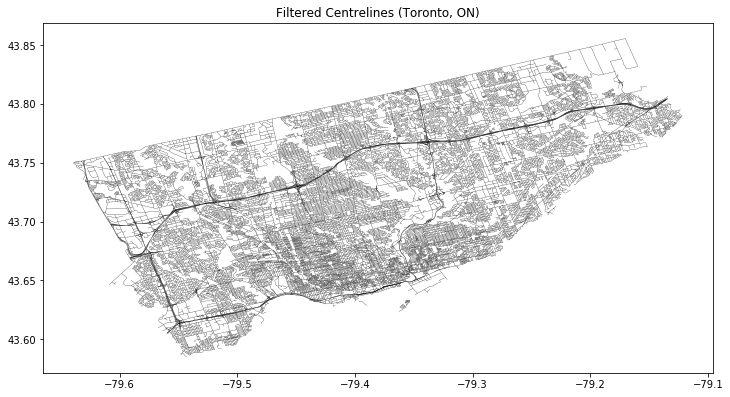

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 8))
clines_map = clines.plot(color = 'black', linewidth = 0.25, ax = ax)
clines_map_title = ax.set_title('Filtered Centrelines (Toronto, ON)')

In [24]:
print('The Coordinate Reference System (CRS) is {}.'.format(clines.crs))

The Coordinate Reference System (CRS) is {'init': 'epsg:4326'}.


#### Join Centrelines with KSI

1. Re-project `centrelines` and `KSI` to UTM-17N
2. Buffer `centreline` by 2.5 meters
3. Spatially join `centrelines` with `KSI` data (left, intersects)
4. Number of collisions for each `centreline` feature

In [25]:
# Re-project to NAD 83 / UTM Zone 17N
utm17n = {'init': 'epsg:26917'}
clines = clines.to_crs(utm17n)
ksi = ksi.to_crs(utm17n)

# Buffer centrelines
clines_buffer = clines.copy()
clines_buffer['geometry'] = clines_buffer.geometry.buffer(2.5)

# Spatial join clines and ksi
clines_sjoin = gpd.sjoin(clines_buffer, ksi, how = 'left', op = 'intersects')
clines_sjoin = clines_sjoin.groupby('GEO_ID').agg(
    GEO_ID = ('GEO_ID', 'first'),
    COLLISIONS = ('ACCNUM', 'count'),
    FCODE = ('FCODE', 'first'),
    FCODE_DESC = ('FCODE_DESC', 'first'),
    geometry = ('geometry', 'first'),
    DATE = ('DATE', 'first'),
    YEAR = ('YEAR', 'first'),
    ROAD_CLASS = ('ROAD_CLASS', 'first'),
    RDSFCOND = ('RDSFCOND', 'first'),
    TRAFFCTL = ('TRAFFCTL', 'first'),
    VISIBILITY = ('VISIBILITY', 'first'),
    LIGHT = ('LIGHT', 'first'),
    DISTRICT = ('DISTRICT', 'first'),
    LOCCOORD = ('LOCCOORD', 'first'),
    IMPACTYPE = ('IMPACTYPE', 'first'),
    PEDESTRIAN = ('PEDESTRIAN', 'prod'),
    CYCLIST = ('CYCLIST', 'prod'),
    AUTOMOBILE = ('AUTOMOBILE', 'prod'),
    MOTORCYCLE = ('MOTORCYCLE', 'prod'),
    TRUCK = ('TRUCK', 'prod'),
    TRSN_CITY_ = ('TRSN_CITY_', 'prod'),
    EMERG_VEH = ('EMERG_VEH', 'prod'),
    PASSENGER = ('PASSENGER', 'prod'),
    SPEEDING = ('SPEEDING', 'prod'),
    AG_DRIV = ('AG_DRIV', 'prod'),
    REDLIGHT = ('REDLIGHT', 'prod'),
    ALCOHOL = ('ALCOHOL', 'prod'),
    DISABILITY = ('DISABILITY', 'prod'),
    PEDESTRIAN_COUNT = ('PEDESTRIAN', 'sum'),
    CYCLIST_COUNT = ('CYCLIST', 'sum'),
    AUTOMOBILE_COUNT = ('AUTOMOBILE', 'sum'),
    MOTORCYCLE_COUNT = ('MOTORCYCLE', 'sum'),
    TRUCK_COUNT = ('TRUCK', 'sum'),
    TRSN_CITY_COUNT = ('TRSN_CITY_', 'sum'),
    EMERG_VEH_COUNT = ('EMERG_VEH', 'sum'),
    PASSENGER_COUNT = ('PASSENGER', 'sum'),
    SPEEDING_COUNT = ('SPEEDING', 'sum'),
    AG_DRIV_COUNT = ('AG_DRIV', 'sum'),
    REDLIGHT_COUNT = ('REDLIGHT', 'sum'),
    ALCOHOL_COUNT = ('ALCOHOL', 'sum'),
    DISABILITY_COUNT = ('DISABILITY', 'sum')
)

# Convert back to geodataframe
clines_sjoin = gpd.GeoDataFrame(clines_sjoin, crs = utm17n)

In [26]:
# Create sample data
clines_buffer_sample = clines_sjoin[clines_sjoin.COLLISIONS > 0].iloc[[0]]
clines_sample = clines[clines.GEO_ID == int(clines_buffer_sample.GEO_ID)]
ksi_sample = gpd.sjoin(ksi, clines_buffer_sample).geometry

# Create example map
clines_example_map = folium.Map(
    tiles = folium_map_style,
    zoom_start = 19,
    location = [
        ksi_sample.geometry.to_crs('epsg:4326').centroid.y,
        ksi_sample.geometry.to_crs('epsg:4326').centroid.x]
)

# Add example data
folium.GeoJson(clines_sample, name = 'Centrelines').add_to(clines_example_map)
folium.GeoJson(ksi_sample, name = 'KSI Collision').add_to(clines_example_map)
folium.GeoJson(clines_buffer_sample.geometry, name = 'Centrelines Buffer').add_to(clines_example_map)

# Display example map
clines_example_map.add_child(folium.map.LayerControl())
clines_example_map

In [27]:
clines_sjoin[clines_sjoin.COLLISIONS > 0].head()

,GEO_ID,COLLISIONS,FCODE,FCODE_DESC,geometry,DATE,YEAR,ROAD_CLASS,RDSFCOND,TRAFFCTL,VISIBILITY,LIGHT,DISTRICT,LOCCOORD,IMPACTYPE,PEDESTRIAN,CYCLIST,AUTOMOBILE,MOTORCYCLE,TRUCK,TRSN_CITY_,EMERG_VEH,PASSENGER,SPEEDING,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,PEDESTRIAN_COUNT,CYCLIST_COUNT,AUTOMOBILE_COUNT,MOTORCYCLE_COUNT,TRUCK_COUNT,TRSN_CITY_COUNT,EMERG_VEH_COUNT,PASSENGER_COUNT,SPEEDING_COUNT,AG_DRIV_COUNT,REDLIGHT_COUNT,ALCOHOL_COUNT,DISABILITY_COUNT
GEO_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
159,159,1,201500,Local,"POLYGON ((636804.503 4841695.436, 636804.440 4...",2013-05-18 04:00:00+00:00,2013.0,Local,Dry,Stop Sign,Clear,Dark,Toronto and East York,Intersection,Rear End,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
214,214,1,201400,Collector,"POLYGON ((632096.486 4841579.170, 632096.424 4...",2014-04-09 04:00:00+00:00,2014.0,Major Arterial,Dry,Traffic Signal,Clear,Daylight,North York,Intersection,Turning Movement,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
241,241,1,201400,Collector,"POLYGON ((630802.680 4841390.617, 630802.924 4...",2016-07-13 04:00:00+00:00,2016.0,Major Arterial,Dry,Traffic Signal,Clear,Daylight,North York,Intersection,Turning Movement,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
242,242,1,201200,Major Arterial,"POLYGON ((630660.818 4841616.343, 630660.796 4...",2016-07-13 04:00:00+00:00,2016.0,Major Arterial,Dry,Traffic Signal,Clear,Daylight,North York,Intersection,Turning Movement,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
267,267,1,201300,Minor Arterial,"POLYGON ((632155.890 4841394.890, 632126.740 4...",2014-04-09 04:00:00+00:00,2014.0,Major Arterial,Dry,Traffic Signal,Clear,Daylight,North York,Intersection,Turning Movement,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [28]:
clines_sjoin.COLLISIONS.iplot(
    'hist',
    title = 'Collisions Frequency Per Centreline Feature',
    xaxis_title = 'Collisions',
    yaxis_title = 'Frequency'
)

In [29]:
print('A total of {} collisions were joined to the centrelines.'.format(clines_sjoin.COLLISIONS.sum()))

A total of 6047 collisions were joined to the centrelines.


#### Calculate Centreline Geometric Measures

* Line Length
* Number of vertices
* Sinuosity (how curved roads are)
    * $Sinuosity = \frac{actual\ line\ length}{straight\ line\ length}$

In [30]:
# Calculate length and vertices
clines_sjoin['line_length'] = clines.geometry.length.to_list()
clines_sjoin['line_vertices'] = [len(x.coords) for x in clines.geometry]

# Calculate sinuosity
clines_first_vertex = gpd.GeoDataFrame(geometry = [Point(g.coords[0]) for g in clines.geometry])
clines_last_vertex = gpd.GeoDataFrame(geometry = [Point(g.coords[-1]) for g in clines.geometry])
clines_length = pd.DataFrame({
    'straight': clines_first_vertex.distance(clines_last_vertex).to_list(),
    'actual': clines.geometry.length.to_list()
})

# Add sinuosity to measures
clines_sjoin['line_sinuosity'] = (clines_length.actual / clines_length.straight).to_list()
clines_sjoin[['line_length', 'line_vertices', 'line_sinuosity']].head()

,line_length,line_vertices,line_sinuosity
GEO_ID,,,
108,168.519392,22,1.032565
117,38.993662,6,1.047115
118,90.234621,5,1.004596
120,93.130354,2,1.000000
121,116.666287,3,1.000003


## Modelling

### Road Collision Prediction

Predict the number of road collisions per centreline feature $i$ given centreline characteristics and KSI variables $X_1 \dots X_N$ (Dummy coded):

$$
Collisions_{i} = f(X_1 \dots X_N)
$$


In [31]:
# Select variables
X = clines_sjoin[[
    'FCODE_DESC',
    'ROAD_CLASS',
    'RDSFCOND',
    'TRAFFCTL',
    'VISIBILITY',
    'LIGHT',
    'DISTRICT',
    'LOCCOORD',
    'line_length',
    'line_vertices',
    'line_sinuosity'
]]
Y = clines_sjoin.COLLISIONS

# Dummy encode
X = pd.get_dummies(X)
X = X.fillna(0)
X = X.replace([np.inf, -np.inf], 0)
X = X.apply(lambda c: c.astype(np.float32))
X.head()

,line_length,line_vertices,line_sinuosity,FCODE_DESC_Access Road,FCODE_DESC_Busway,FCODE_DESC_Collector,FCODE_DESC_Collector Ramp,FCODE_DESC_Expressway,FCODE_DESC_Expressway Ramp,FCODE_DESC_Laneway,FCODE_DESC_Local,FCODE_DESC_Major Arterial,FCODE_DESC_Major Arterial Ramp,FCODE_DESC_Minor Arterial,FCODE_DESC_Minor Arterial Ramp,FCODE_DESC_Other,FCODE_DESC_Other Ramp,FCODE_DESC_Pending,FCODE_DESC_Walkway,ROAD_CLASS_,ROAD_CLASS_Collector,ROAD_CLASS_Expressway,ROAD_CLASS_Laneway,ROAD_CLASS_Local,ROAD_CLASS_Major Arterial,ROAD_CLASS_Minor Arterial,ROAD_CLASS_Other,ROAD_CLASS_Pending,RDSFCOND_,RDSFCOND_Dry,RDSFCOND_Ice,RDSFCOND_Loose Sand or Gravel,RDSFCOND_Loose Snow,RDSFCOND_Other,RDSFCOND_Packed Snow,RDSFCOND_Slush,RDSFCOND_Wet,TRAFFCTL_,TRAFFCTL_No Control,TRAFFCTL_Pedestrian Crossover,TRAFFCTL_Police Control,TRAFFCTL_Stop Sign,TRAFFCTL_Streetcar (Stop for),TRAFFCTL_Traffic Controller,TRAFFCTL_Traffic Signal,TRAFFCTL_Yield Sign,VISIBILITY_,VISIBILITY_Clear,VISIBILITY_Drifting Snow,"VISIBILITY_Fog, Mist, Smoke, Dust",VISIBILITY_Freezing Rain,VISIBILITY_Other,VISIBILITY_Rain,VISIBILITY_Snow,VISIBILITY_Strong wind,LIGHT_Dark,"LIGHT_Dark, artificial",LIGHT_Dawn,"LIGHT_Dawn, artificial",LIGHT_Daylight,"LIGHT_Daylight, artificial",LIGHT_Dusk,"LIGHT_Dusk, artificial",LIGHT_Other,DISTRICT_,DISTRICT_Etobicoke York,DISTRICT_North York,DISTRICT_Scarborough,DISTRICT_Toronto East York,DISTRICT_Toronto and East York,LOCCOORD_,LOCCOORD_Intersection,LOCCOORD_Mid-Block,"LOCCOORD_Park, Private Property, Public Lane"
GEO_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
108,168.519394,22.0,1.032565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,38.993660,6.0,1.047115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,90.234619,5.0,1.004596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,93.130356,2.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,116.666290,3.0,1.000003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
print('Total of {} variables.'.format(len(X.columns)))

Total of 74 variables.


### Variable Selection

* Random Forest Regressor to select most important variables
* Based on mean variable importance

In [33]:
# Build selection model
selector = SelectFromModel(RandomForestRegressor(n_estimators = 100))
selector.fit(X, Y)

# Select variables from X
selected_variables = X.columns[(selector.get_support())]
X = X[selected_variables]
X.head()

,line_length,line_vertices,line_sinuosity,TRAFFCTL_No Control,TRAFFCTL_Traffic Signal,VISIBILITY_Clear,LOCCOORD_Intersection,LOCCOORD_Mid-Block
GEO_ID,,,,,,,,
108,168.519394,22.0,1.032565,0.0,0.0,0.0,0.0,0.0
117,38.993660,6.0,1.047115,0.0,0.0,0.0,0.0,0.0
118,90.234619,5.0,1.004596,0.0,0.0,0.0,0.0,0.0
120,93.130356,2.0,1.000000,0.0,0.0,0.0,0.0,0.0
121,116.666290,3.0,1.000003,0.0,0.0,0.0,0.0,0.0


In [34]:
print('Total of {} selected variables.'.format(len(X.columns)))

Total of 8 selected variables.


### Machine Learning Models

* Linear Regression (LR): linear relationships, simple 
* Random Forest Regressor (RFR): ensemble of decision trees
* Multi Layer Perceptron Regressor (MLPR): neural network optimizing for loss

In [35]:
LR_model = LinearRegression()
LR_model.fit(X, Y)

RFR_model = RandomForestRegressor(n_estimators = 100)
RFR_model.fit(X, Y)

MLPR_model = MLPRegressor(activation = 'logistic')
MLPR_model.fit(X, Y)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [36]:
LR_cv = cross_validate(LR_model, X, Y, cv = 10, scoring = 'r2')
LR_scores = pd.DataFrame(LR_cv)
LR_scores.iplot(
    'line',
    y = 'test_score',
    title = 'Linear Regression (10-fold Cross Validation)',
    yaxis_title = 'R^2'
)

In [37]:
print('Mean R^2: {}'.format(LR_scores.test_score.mean()))

Mean R^2: 0.7370366518577595


In [38]:
RFR_cv = cross_validate(RFR_model, X, Y, cv = 10, scoring = 'r2')
RFR_scores = pd.DataFrame(RFR_cv)
RFR_scores.iplot(
    'line',
    y = 'test_score',
    title = 'Random Forest Regressor (10-fold Cross Validation)',
    yaxis_title = 'R^2'
)

In [39]:
print('Mean R^2: {}'.format(RFR_scores.test_score.mean()))

Mean R^2: 0.6589371374001527


In [40]:
MLPR_cv = cross_validate(MLPR_model, X, Y, cv = 10, scoring = 'r2')
MLPR_scores = pd.DataFrame(MLPR_cv)
MLPR_scores.iplot(
    'line',
    y = 'test_score',
    title = 'Multi Layer Perceptron Regressor (10-fold Cross Validation)',
    yaxis_title = 'R^2'
)

In [41]:
print('Mean R^2: {}'.format(MLPR_scores.test_score.mean()))

Mean R^2: 0.7311185287417293


### Predicting Number of Road Collisions

* Predict on each feature
* Sum to compare totals

In [42]:
predictions = pd.DataFrame({
    'LR': LR_model.predict(X),
    'RFR': RFR_model.predict(X),
    'MLPR': MLPR_model.predict(X),
    'ACTUAL': Y
})
predictions.head()

,LR,RFR,MLPR,ACTUAL
GEO_ID,,,,
108,0.002339,0.0,-0.023309,0
117,0.000202,0.0,-0.003689,0
118,0.000756,0.0,-0.016249,0
120,0.000623,0.0,-0.013447,0
121,0.000890,0.0,-0.015374,0


In [43]:
predictions.sum().iplot(
    'bar',
    title = 'Predicted Number of Road Collisions'
)

## Experiments

### What If We?

* Changed the number of traffic signals?
* Made roads longer?

In [61]:
rows = len(X.index)
X.describe()

,line_length,line_vertices,line_sinuosity,TRAFFCTL_No Control,TRAFFCTL_Traffic Signal,VISIBILITY_Clear,LOCCOORD_Intersection,LOCCOORD_Mid-Block
count,51514.000000,51514.000000,51514.000000,51514.000000,51514.000000,51514.000000,51514.000000,51514.000000
mean,125.588562,6.065555,1.049492,0.031914,0.039620,0.071301,0.069748,0.013084
std,110.451050,10.725196,0.434922,0.175772,0.195067,0.257329,0.254724,0.113635
min,0.732433,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.638315,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.591522,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,163.392254,5.000000,1.003284,0.000000,0.000000,0.000000,0.000000,0.000000
max,1877.720459,254.000000,45.297741,1.000000,1.000000,1.000000,1.000000,1.000000


In [90]:
# Create separate dataframe
X_signal_inc = X.copy()
no_signal = X_signal_inc['TRAFFCTL_Traffic Signal'] < 1
no_signal_rows = len(X_signal_inc[no_signal].index)

# Randomly sample and assign
X_signal_inc_sample = X_signal_inc[['TRAFFCTL_Traffic Signal']][no_signal].sample(int(no_signal_rows * 0.1))
X_signal_inc_sample['TRAFFCTL_Traffic Signal'].values[:] = 1

# Update
X_signal_inc.update(X_signal_inc_sample)

# Predict
predictions_signal_inc = pd.DataFrame({
    'LR': LR_model.predict(X_signal_inc),
    'RFR': RFR_model.predict(X_signal_inc),
    'MLPR': MLPR_model.predict(X_signal_inc)
})

# Plot
predictions_signal_inc_diff = predictions.sum() - predictions_signal_inc.sum()
predictions_signal_inc_diff = predictions_signal_inc_diff.drop('ACTUAL')
predictions_signal_inc_diff.iplot(
    'bar',
    title = 'Predicted Changes After 10% increase in Traffic Signals'
)

In [97]:
# Create separate dataframe
X_road_longer = X.copy()

# Randomly sample and assign
X_road_longer_sample = X_signal_inc[['line_length']].sample(int(no_signal_rows * 0.25))
X_road_longer_sample['line_length'].values[:] = X_road_longer_sample['line_length'] * 1.2

# Update
X_road_longer.update(X_road_longer_sample)

# Predict
predictions_road_longer = pd.DataFrame({
    'LR': LR_model.predict(X_road_longer),
    'RFR': RFR_model.predict(X_road_longer),
    'MLPR': MLPR_model.predict(X_road_longer)
})

# Plot
predictions_road_longer_diff = predictions.sum() - predictions_road_longer.sum()
predictions_road_longer_diff = predictions_road_longer_diff.drop('ACTUAL')
predictions_road_longer_diff.iplot(
    'bar',
    title = 'Predicted Changes After Lengthening 25% of Roads by 20%'
)

## Conclusion

### Summary

* Road collisions not random, can be predicted
* Temporal effect seen, but not thoroughly examined
* Models can be unstable, more work needed for hyperparameter tuning


### Future Work

* Incorporate Temporal Measures and Other Geographic Entities
* Examine Social Media Data
* Build Software for Experimenting with All Variables

Richard Wen
  
  
PhD Candidate, Geomatics Engineering  
rwen@ryerson.ca

More Details at: [github.com/rrwen/experiment-predict-toronto-geocrash](https://github.com/rrwen/experiment-predict-toronto-geocrash)